### Objective:

* Data Wrangling and Exploration (handle missing values etc.).
* Correlation analysis with Store dataset joined.
* Training Model with RF
* Visualize and evaluate model
* Choose the best performing one and predict the next 6 weeks of sales

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from pandas import datetime

In [3]:
### Visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

In [4]:
import os
PATH = os.getcwd()
print(PATH)

C:\Users\kk\Desktop\Rossmann Store Sales


In [5]:
train = pd.read_csv('train.csv', parse_dates = True, low_memory = False, index_col = 'Date')

In [6]:
train.describe(include = 'all')

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,986159,NaN
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [7]:
store = pd.read_csv('store.csv', low_memory = False)

### Exploratory Data Analysis

* Here we go through the train and store data, handle missing values and create new features for further analysis.

### Train Data

In [8]:
train.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1


In [9]:
train.shape

(1017209, 8)

### Short description:
* Sales: turnover for any given day (Target variable).
* Customers: number of customers on a given day.
* Open: an indicator for whether the store was open: 0 = closed, 1 = open.
* Promo: indicates whether a store is running a promo on that day.
* StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
* SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

* We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.


In [10]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

### adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

#### On average customers spend about 9.50$ per day.

* To get the first impression about continious variables in the data

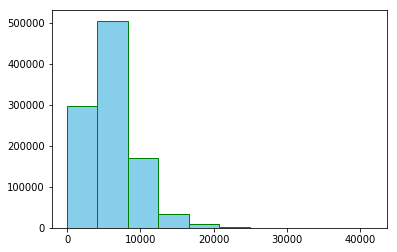

In [11]:
plt.hist(train['Sales'],
        facecolor = 'skyblue',
        edgecolor = 'green')
plt.show()


* Almost 80% of time daily amount of sales was less than 10000.

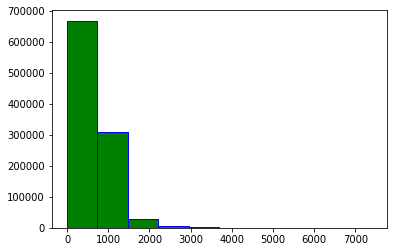

In [12]:
plt.hist(train['Customers'],
        facecolor = 'green',
        edgecolor = 'blue')
plt.show()

* zero sales, it only due to the fact that the store is closed

### Closed stores & zero sales stores

In [13]:
# closed stores
closed_stores = train[(train.Open == 0) & (train.Sales == 0)]
closed_stores.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN


In [14]:
closed_stores.shape

(172817, 13)

* There're 172817 closed stores in the data. To avoid any biased forecasts we will drop these values.

### Opened stores & zero sales

In [15]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
zero_sales.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN


In [16]:
zero_sales.shape

(54, 13)

* There are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved.

* Data of Closed stores & days which didn't have any sales won't be counted into the forecasts.

In [17]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

In [18]:
train.shape

(844338, 13)

### Store data

In [19]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [20]:
store.shape

(1115, 10)

### Short Description

* Store: a unique Id for each store
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Missing Values

In [21]:
# Checking for Missing values 
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

* We have few variables with missing values

* The Promo2SinceWeek,Promo2SinceYear and PromoInterval variables has 51% fill rate since they are actually NULL values because there are no continuous promotion for those stores.

### Data Types

In [22]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [23]:
store.describe(include = 'all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


In [24]:
store['CompetitionDistance'].median()

2325.0

In [25]:
store['CompetitionDistance'].mean()

5404.901079136691

*  replace NaN with the median values which is twice less that the average.

In [26]:
# fill NaN with a median value
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

* Replacing NA'S with Zero

In [27]:
# replace NA's by 0
store.fillna(0, inplace = True)

* Joining train set with an additional store information.

In [28]:
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

* By specifying inner join we make sure that only those observations that are present in both train and store sets are merged together

In [29]:
train_store.shape

(844338, 22)

In [30]:
train_store.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store Type

* In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [31]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


* StoreType B has the highest average of Sales among all others, but we have much less data for it. So we looking at overall sum of Sales and Customers to see which StoreType is the most selling.

In [32]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


* Clearly stores of type A has highest Sales and Customers. StoreType D goes to the second place in both Sales and Customers.

#### Assortments:

* As we cited in the description, assortments have three types and each store has a defined type and assortment type:

* a means basic things
* b means extra things
* c means extended things so the highest variety of products.

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

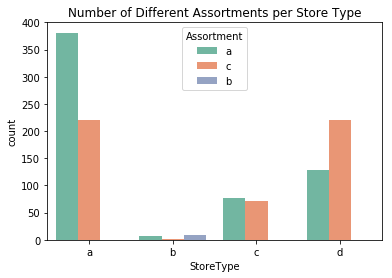

In [33]:
StoretypeXAssortment = sns.countplot(x = "StoreType", hue = "Assortment", order=["a","b","c","d"], data = store, 
                                     palette = sns.color_palette("Set2", n_colors=3)).set_title("Number of Different Assortments per Store Type")
store.groupby(by=["StoreType","Assortment"]).Assortment.count()

#### Findings:

* We can clearly see here that most of the stores have either a assortment type or c assortment type.
* StoreType d which has the highest Sales per customer average actually has mostly c assortment type, this is most probably the reason for having this high average in Sales per customer.Having variery in stores always increases the customers spending pattern.
* Another important factor here is the fact that store type b is the only one who has the b assortment type

### Correlation Analysis

In [34]:
corr = train_store[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
        'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'SalePerCustomer', 'Month', 'Year',
       'Day']]

In [35]:
corr = train_store.drop('Open', axis = 1).corr()

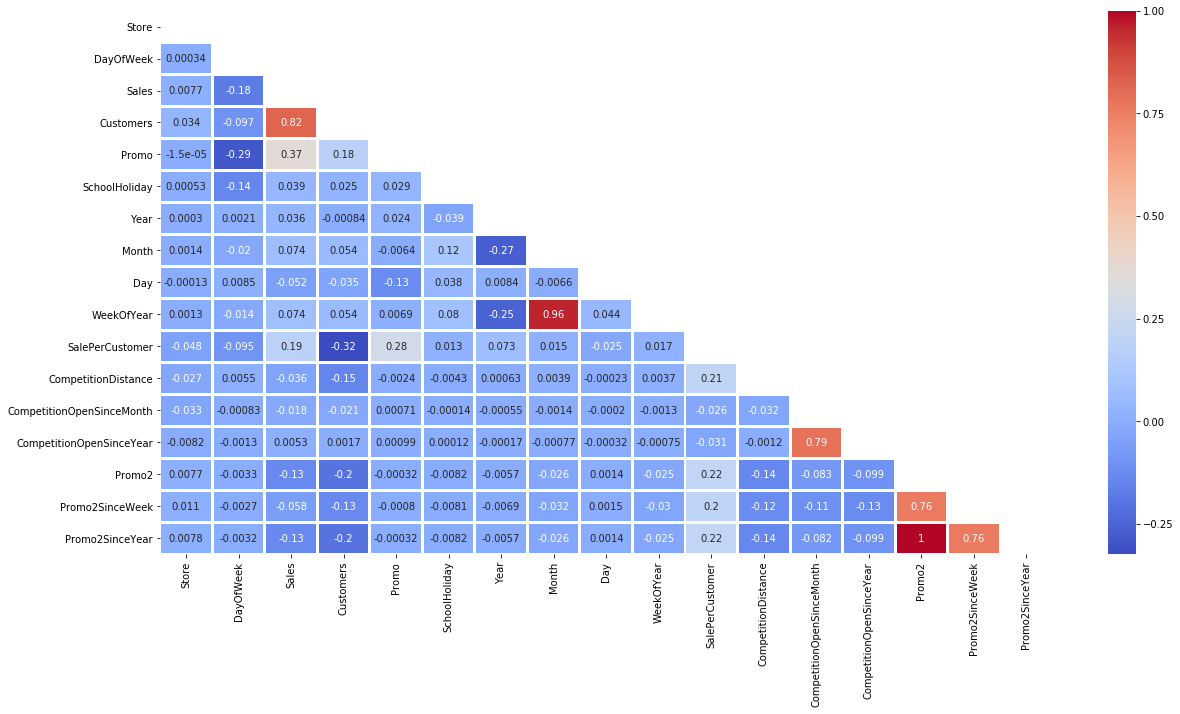

In [36]:
# Compute the correlation matrix 
# exclude 'Open' variable
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.heatmap(corr, cmap = 'coolwarm', ax = ax, mask = mask, annot = True,linewidths=2)

*  we have a strong positive correlation between the amount of Sales and Customers of a store.
* Since the competition variables CompetitionOpenSinceYear and CompeitionOpenSinceMonth have the same underlying meaning, merging them into one variable that we call CompetitionOpenSince
* t's interesting to see that Sales per Customer and Promo (0.28) actually correlate positively, since running a promotion increases that number.

In [37]:
train_store['CompetitionOpenSince'] = np.where((train_store['CompetitionOpenSinceMonth']==0) & (train_store['CompetitionOpenSinceYear']==0) , 0,(train_store.Month - train_store.CompetitionOpenSinceMonth) + 
                                       (12 * (train_store.Year - train_store.CompetitionOpenSinceYear)) )

#### Dropping Columns

In [38]:
#now that CompetitionOpenSince is created 
#we can get rid of `CompetitionOpenSinceYear` and `CompeitionOpenSinceMonth`
del train_store['CompetitionOpenSinceYear']
del train_store['CompetitionOpenSinceMonth']

In [39]:
train_store["is_holiday_state"] = train_store['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})

In [40]:
train_store['StateHoliday'].value_counts()

0    843428
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

* The StateHoliday is not very important to distinguish (what type of holiday) and can be merged in a binary variable called is_holiday_state.

In [41]:
train_store.shape

(844338, 22)

In [42]:
train_store['is_holiday_state'].value_counts()

0    843428
1       910
Name: is_holiday_state, dtype: int64

### Conclusions of EDA

* The most selling and crowded StoreType is A.
* The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart.
* Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things.

In [43]:
for cols in ['StateHoliday', 'PromoInterval', 'StoreType','Assortment']:
    train_store[cols] = train_store[cols].astype('category')

In [44]:
del train_store['StateHoliday']

### Train & Test Split

In [45]:
### Assigning Dependent(Target) & Independent Variables.
#a rule of thumb is to transform my target value to log if i see the values are very dispersed which is the case
#and then of course revert them with np.exp to their real values
x = train_store.drop(['Customers', 'Sales', 'SalePerCustomer'], axis = 1)
y = np.log(train_store.Sales)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=123)  

In [48]:
X_train.shape

(675470, 18)

In [49]:
X_test.shape

(168868, 18)

In [50]:
y_train.shape

(675470,)

In [51]:
y_test.shape

(168868,)

### Split the attributes into numerical and categorical types

In [52]:
num_attr=X_train.select_dtypes(['int64','float64']).columns
num_attr

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'CompetitionOpenSince', 'is_holiday_state'],
      dtype='object')

In [53]:
cat_attr = X_train.select_dtypes('category').columns
cat_attr

Index(['StoreType', 'Assortment', 'PromoInterval'], dtype='object')

#### Handling Categorical Data

In [54]:
X_train = pd.get_dummies(columns=cat_attr,data=X_train,drop_first=True)

In [55]:
X_test = pd.get_dummies(columns=cat_attr,data=X_test,drop_first=True)

In [56]:
X_train.head(2)

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,...,CompetitionOpenSince,is_holiday_state,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
379957,503,6,1,0,0,2013,12,21,51,13080.0,...,87.0,0,0,0,1,0,1,0,1,0
390916,517,4,1,1,0,2013,3,21,12,22490.0,...,0.0,0,0,0,0,0,1,0,0,0


### Test Data

In [57]:
test = pd.read_csv('test.csv', parse_dates = True, low_memory = False, index_col = 'Date')

In [58]:
test.head(3)

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0


In [59]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

In [60]:
test.shape

(41088, 11)

### Missing Values

In [61]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
Year              0
Month             0
Day               0
WeekOfYear        0
dtype: int64

In [62]:
test.fillna(1, inplace = True)

### Merging Test & Store Data

In [63]:
test_store = pd.merge(test, store, how = 'left', on = 'Store')

In [64]:
test_store.shape

(41088, 20)

In [65]:
test_store['StateHoliday'].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [66]:
test_store["is_holiday_state"] = test_store['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})

In [67]:
test_store['is_holiday_state'].value_counts()

0    40908
1      180
Name: is_holiday_state, dtype: int64

In [68]:
test_store.head(3)

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,is_holiday_state
0,1,1,4,1.0,1,0,0,2015,9,17,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,0
1,2,3,4,1.0,1,0,0,2015,9,17,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0
2,3,7,4,1.0,1,0,0,2015,9,17,...,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0,0


### Data Types

In [69]:
test_store.dtypes

Id                             int64
Store                          int64
DayOfWeek                      int64
Open                         float64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
Year                           int64
Month                          int64
Day                            int64
WeekOfYear                     int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
is_holiday_state               int64
dtype: object

In [70]:
for cols in ['StateHoliday', 'PromoInterval', 'StoreType','Assortment']:
    test_store[cols]=test_store[cols].astype('category')

In [71]:
test_store['CompetitionOpenSince'] = np.where((test_store['CompetitionOpenSinceMonth']==0) & (test_store['CompetitionOpenSinceYear']==0) , 0,(test_store.Month - test_store.CompetitionOpenSinceMonth) + 
                                       (12 * (test_store.Year - test_store.CompetitionOpenSinceYear)) )

#### Dropping Columns

In [72]:
#now that CompetitionOpenSince is created 
#we can get rid of `CompetitionOpenSinceYear` and `CompeitionOpenSinceMonth`
del test_store['CompetitionOpenSinceYear']
del test_store['CompetitionOpenSinceMonth']

In [73]:
del test_store['StateHoliday']

In [74]:
test_store.head(5)

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,is_holiday_state,CompetitionOpenSince
0,1,1,4,1.0,1,0,2015,9,17,38,c,a,1270.0,0,0.0,0.0,0,0,84.0
1,2,3,4,1.0,1,0,2015,9,17,38,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0,105.0
2,3,7,4,1.0,1,0,2015,9,17,38,a,c,24000.0,0,0.0,0.0,0,0,29.0
3,4,8,4,1.0,1,0,2015,9,17,38,a,a,7520.0,0,0.0,0.0,0,0,11.0
4,5,9,4,1.0,1,0,2015,9,17,38,a,c,2030.0,0,0.0,0.0,0,0,181.0


### Split the attributes into numerical and categorical types

In [75]:
num_attr_test=test_store.select_dtypes(['int64','float64']).columns
num_attr_test

Index(['Id', 'Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year',
       'Month', 'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_holiday_state',
       'CompetitionOpenSince'],
      dtype='object')

In [76]:
cat_attr_test = test_store.select_dtypes(['category']).columns
cat_attr_test

Index(['StoreType', 'Assortment', 'PromoInterval'], dtype='object')

### Handling Categorical data

In [77]:
test_store = pd.get_dummies(columns = cat_attr_test, data = test_store, drop_first = True)

In [78]:
test_store.head(2)

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,...,is_holiday_state,CompetitionOpenSince,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,1,4,1.0,1,0,2015,9,17,38,...,0,84.0,0,1,0,0,0,0,0,0
1,2,3,4,1.0,1,0,2015,9,17,38,...,0,105.0,0,0,0,0,0,0,1,0


### Defining Performance Metric

In [79]:
def rmspe(y, y_hat):
    rmspe = np.sqrt(np.mean( (y - y_hat)**2 ))
    return rmspe

###  Build Random Forest Regressor

* RandomForest is a machine learning alogrithm used for classification and regression that is bestly used with structured and tabular data.

#### Its advantages:

* Random forest runtimes are quite fast, and they are able to deal with unbalanced and missing data.
* The process of averaging or combining the results of different decision trees helps to overcome the problem of overfitting.
* They also do not require preparation of the input data. You do not have to scale the data.

#### Its Disadvantages:

* The main drawback of Random Forests is the model size. You could easily end up with a forest that takes hundreds of megabytes of memory and is slow to evaluate.
* They get a bit harder to interpret than regular deicison trees, since we are constructing of forest of more than 50 decision trees and more using grid search.

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
rfr = RandomForestRegressor(n_estimators=10, 
                             criterion='mse', 
                             max_depth=5, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4,
                             random_state=31, 
                             verbose=0, 
                             warm_start=False)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                      oob_score=False, random_state=31, verbose=0,
                      warm_start=False)

In [82]:
y_hat = rfr.predict(X_test)

(array([2.2900e+02, 2.2000e+01, 3.4500e+02, 4.8700e+02, 8.7872e+04,
        2.1798e+04, 4.8567e+04, 8.7690e+03, 4.3700e+02, 3.4200e+02]),
 array([7.66037093, 7.86831389, 8.07625686, 8.28419982, 8.49214279,
        8.70008575, 8.90802872, 9.11597168, 9.32391465, 9.53185761,
        9.73980058]),
 <a list of 10 Patch objects>)

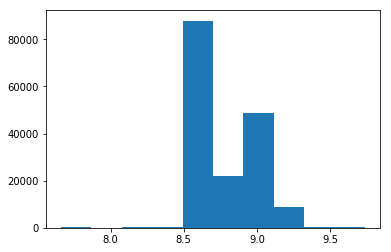

In [83]:
plt.hist(y_hat)

In [84]:
error = rmspe(y_test,y_hat)
error

0.36088097287393667

In [85]:
rfr.feature_importances_

array([8.94767662e-04, 8.44804002e-02, 0.00000000e+00, 6.03981403e-01,
       0.00000000e+00, 1.27074545e-05, 6.92462121e-03, 1.69894449e-03,
       3.60800839e-02, 7.72712208e-02, 1.63495045e-03, 3.27554167e-03,
       6.74904306e-02, 0.00000000e+00, 0.00000000e+00, 5.43571278e-02,
       0.00000000e+00, 0.00000000e+00, 2.26103885e-03, 5.96367621e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [86]:
importances = rfr.feature_importances_
indices = np.argsort(importances)
print(indices)

[22 20  2 17  4 16 14 13 21  5  0 10  7 18 11  6  8 15 19 12  9  1  3]


### Important Variables

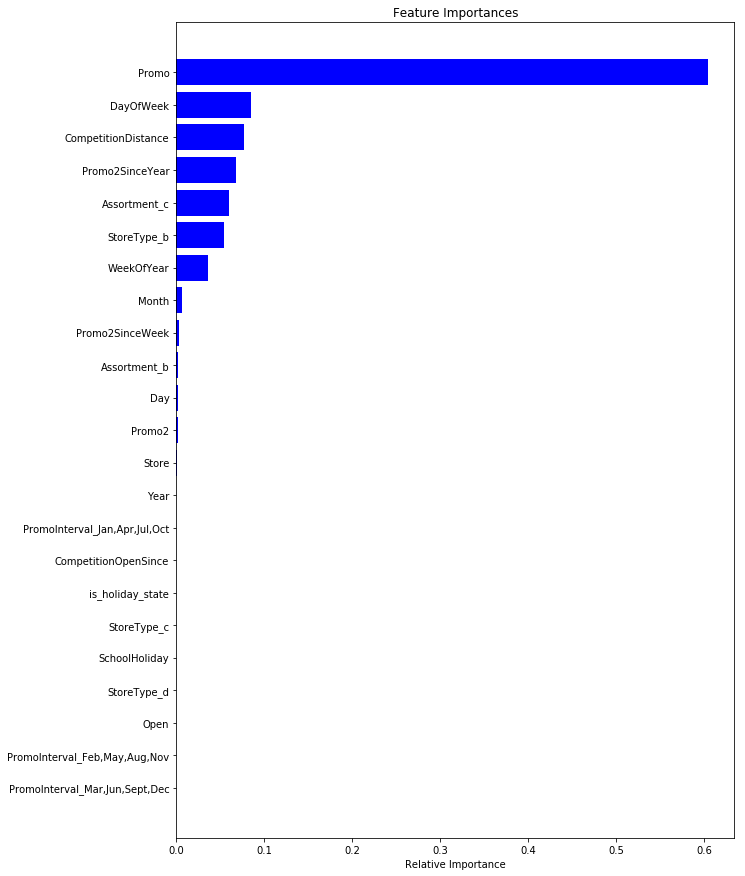

In [87]:
features = X_train.columns

plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

### Test our RF on the validation set:

In [ ]:
%%time
#with the optimal parameters i got let's see how it behaves with the validation set
rfr_val=RandomForestRegressor(n_estimators=128, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, #setting n_jobs to 4 makes sure you're using the full potential of the machine you're running the training on
                             random_state=35, 
                             verbose=0, 
                             warm_start=False)
model_RF_test = rfr_val.fit(X_train,y_train)

In [ ]:
y_gs=model_RF_test.predict(X_test)

In [ ]:
plt.hist(y_gs)

In [ ]:
error_ = rmspe(y_test,y_gs)
error_

* Well 0.16 on RMSPE is a very good measure.

#### Results:

* At this stage with an RMSPE of 0.16 we're quite accurate when it comes to testing our validation set. A lot of approaches can be taken here in order to improve this score:

-Either allocating more training sample when splitting so that the algorithm has more data to train on.

-Proposing more variation in the hyperparameter to reach a better optimal combination.

-Use another approach then RandomForest like polynomial linear regression,XGboost,Neural Network etc.

### Important Variables

In [ ]:
import itertools

In [ ]:
rfr_val.feature_importances_

In [ ]:
importances = rfr_val.feature_importances_
std = np.std([rfr_val.feature_importances_ for tree in rfr_val.estimators_],
             axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette())
# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest

plt.figure(figsize=(10,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()


#### Findings:

Our top 5 most important variables are:

1-Competitor Distance: This indeed impacts a lot the sales of a store like we saw previously in our EDA,when competition is very far stores tend to sell a lot more.

2-Promo: Promotion is primordial for a store to increase its sales, it allows price breaking and thus more customers intersted in buying.

3-Store: The Store itself represents a unique identificator for the algorithm to recognise which store has what attributes and indeed better accounts for the forecasting of those same stores in a future timeline.

4-CompetitionOpenSince: The merging of this variable paid out and allowed us to give more accurate predicitions of the sales based on the time of opening of those competitors.

5-DayofWeek: Like we said, during a week , the pattern varies a lot if it's a sunday or a monday (like we saw in our EDA) for instance and each day in the week has his own attributes and properties that allow to know how much are we going to sell.

### Submission

In [ ]:
test_store1 = test_store.drop(['Id'],axis=1)

kaggle_yhat= model_RF_test.predict(test_store1)
kaggle_preds= pd.DataFrame({'Id': test_store['Id'], 
                          'Sales': np.exp(kaggle_yhat)})


In [ ]:

kaggle_preds.to_csv("Yasin_RF_Rossman_Kaggle_submission.csv", index = False)

In [ ]:
final = pd.read_csv('Yasin_RF_Rossman_Kaggle_submission.csv')

In [ ]:
final.head(3)

### Conclusion of project:

* The flexibility and robustness of a decision tree based model like RandomForest which helped us predict the Store Sales of Rossman based on attributes that defines each store and its surroundings.
* We had a train set that was large enough for it to converge but in general RandomForest performs not so bad on small sets since its resampling method.
* Even in this case always performs good on unseen data where as XGboost has tendency to overfit if not gently and smartly tuned.
* Using hyperparameter optimization techniques like Gridsearch and RandomizedSearch is crucial to any Machine Learning problem.